In [1]:
import numpy as np
import pandas as pd
import os
import torch
from utils.csv_to_pd import *
from utils.lstm_tool import *

In [2]:

def get_full_9_17(df: pd.DataFrame) -> list[tuple[int, int, np.ndarray]]:
    """
    取得9點~17點
    每10分鐘都有資料的那幾天的發電量

    資料先後順序:
    location, month_day, label_np
    """

    location = df["LocationCode"].unique()
    used_train_data = []
    for l in location:
        l_df = df[df["LocationCode"] == l]
        month_day = l_df["month_day"].unique()
        for md in month_day:
            l_md_df = l_df[l_df["month_day"] == md]
            if len(l_md_df) == 48:
                used_train_data.append((int(l), int(md), np.array(l_md_df['Power(mW)'])))
    return used_train_data

def get_data_label(df: pd.DataFrame, target_data: tuple):
    """
    根據target_data的location, month_day, label_np

    取得同個地點、日期所有9:00~17:00以前的數據紀錄

    回傳:
    資料長度、資料、標籤
    """


    location, month_day, label_np = target_data

    support_data = []
    for i in range(9, 17):
        for _ in range(6):
            support_data.append([location / 17, int(month_day / 100) / 12, (i - 9) / 7])

    target_df = df[df["LocationCode"] == location].copy() 
    target_df = target_df[target_df["month_day"] == month_day]

    if len(target_df) < 60:
        return None


    target_df = target_df.drop(columns=['month_day'])
    target_df["LocationCode"] = target_df["LocationCode"] / 17

    data = np.array(target_df)
    label = label_np

    
    return len(data), (data, support_data), label
def get_data_label_list(target_df, target_datas):
    feature_df = get_features(target_df)

    data_label_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        if data_label != None:
            data_label_list.append(data_label)
    return data_label_list

def get_upload_data_list(target_df, target_datas):########################
    feature_df = get_features(target_df)
    
    data_list = []
    support_data_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        
        if data_label != None:
            _, data_tuple, _ = data_label
            data, support_data = data_tuple
            data_list.append(torch.from_numpy(np.array(data)))
            support_data_list.append(torch.from_numpy(np.array(support_data)))
    return data_list, support_data_list


def get_batch(data: list, support_data: list, label: list, batch_size=64):
    """
    將data跟label根據batch_size切成batch
    """


    batch_datas = []
    batch_labels = []
    batch_support_data = []
    for i in range(0, len(data), batch_size):
        this_batch_length = len(data[i])
        batch_data = []
        for j in range(i, min(i + batch_size, len(data))):
            batch_data.append(data[j][-this_batch_length:len(data[j])])
        
        batch_datas.append(torch.from_numpy(np.array(batch_data)))
        batch_support_data.append(torch.from_numpy(np.array(support_data[i:i + batch_size])))
        batch_labels.append(torch.from_numpy(np.array(label[i:i + batch_size])))
    return batch_datas, batch_support_data, batch_labels

def get_upload_target_list(path="36_TestSet_SubmissionTemplate/upload(no answer).csv"):
    """
    取得上傳答案所需的資料
    格式df, 需要處理的對象
    """

    upload = pd.read_csv(path)
    upload_target_set = set()
    upload_target_list = []
    for u_target in list(upload['序號']):
        month_day = int((u_target % 1e10) / 1e6)
        location = int(u_target % 100)
        if not month_day * 100 + location in upload_target_set:
            upload_target_set.add(month_day * 100 + location)
            upload_target_list.append((location, month_day, np.array(list(range(48)))))
    return upload, upload_target_list


def get_features(target_df: pd.DataFrame, before_time=9, start_time=4):
    feature_df_before = target_df[target_df['DateTime'].dt.hour < before_time]
    feature_df_before = feature_df_before[feature_df_before['DateTime'].dt.hour > start_time]
    feature_df_before = feature_df_before.drop(columns=['DateTime'])

    return feature_df_before



In [3]:
from sklearn.preprocessing import StandardScaler

#取得做完各種處理的dataframe
target_df = read_dir_csv()
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])
target_df["month_day"] = target_df['DateTime'].dt.month * 100 + target_df['DateTime'].dt.day
target_df['month'] = target_df['DateTime'].dt.month
target_df['hour'] = target_df['DateTime'].dt.hour

#取得所有可用的訓練資料 target_datas
after_9 = target_df[target_df['DateTime'].dt.hour >= 9].drop(columns=["WindSpeed(m/s)", "Pressure(hpa)", "Temperature(°C)", "Humidity(%)", "Sunlight(Lux)"])
between_9_17 = after_9[after_9['DateTime'].dt.hour < 17]
mean_10_between_9_17 = mean_10min(between_9_17)
target_datas = get_full_9_17(mean_10_between_9_17)

# 標準化
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', "month", "Power(mW)", 'hour']
scaler = StandardScaler()
target_df[columns_to_standardize] = scaler.fit_transform(target_df[columns_to_standardize])



c:\Users\weiso131\Desktop\power_generation_predict\utils\csv_to_pd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])


In [4]:
# 根據target_datas生成train和valid
data_label_list = get_data_label_list(target_df, target_datas)


In [7]:

train_data_label_list, valid_data_label_list = split_data_random(data_label_list, train_ratio=0.9)
train_data_tuple, train_label, train_length = sort_by_length(train_data_label_list)
train_data, train_support_data = list(zip(*train_data_tuple))
valid_data_tuple, valid_label, valid_length = sort_by_length(valid_data_label_list)
valid_data, valid_support_data = list(zip(*valid_data_tuple))
#print(len(data_label_list)), print(train_data[0].shape), print(len(train_support_data)), print(len(train_data))
print(train_data[0].shape)

(83, 9)


In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size=1, input_dim=8, support_dim=3):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM層
        self.feature_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.output_lstm = nn.LSTM(support_dim, hidden_dim, batch_first=True)


        # 線性層
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))

    def forward(self, data, support, hidden):
        """
        sentence: Tensor, shape (batch_size, seq_len, input_dim)
        hidden: Initial hidden state

        Returns:
            tag_space: Tensor, shape (batch_size, tagset_size)
            hidden: Final hidden state
        """
        # LSTM層
        _, hidden = self.feature_lstm(data, hidden)

        output, hidden = self.output_lstm(support, hidden)

        # 線性層和激活函數
        tag_space = self.relu(self.linear(self.relu(output)))

        return tag_space, hidden


In [7]:
import torch.optim as optim

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, train_length, valid_length, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    min_loss = 1e9

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, support_datas, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)

            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            train_loss += loss.item()

        

        # 驗證模型
        valid_loss, valid_error  = validate_model(model, valid_loader, criterion, valid_length)
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(), "checkpoint.pth" )
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / train_length:.4f}")
            print(f"valid_loss:{valid_loss}, valid_error:{valid_error}")


# 定義驗證函數
def validate_model(model, valid_loader, criterion, valid_length):
    model.eval()
    total_loss = 0.0
    error = 0
    count = 0
    with torch.no_grad():
        for inputs, support_datas, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += abs(outputs.view(-1) - labels.view(-1)).sum()
            count += labels.shape[0] * labels.shape[1]
            total_loss += loss.item()

    return total_loss / valid_length, error / count


In [20]:
batch = 64
batch_train_data, batch_train_support_data, batch_train_label = get_batch(train_data, train_support_data, train_label, batch)
batch_valid_data, batch_valid_support_data, batch_valid_label = get_batch(valid_data, valid_support_data, valid_label, batch)
train_loader = list(zip(batch_train_data, batch_train_support_data, batch_train_label))
valid_loader = list(zip(batch_valid_data, batch_valid_support_data, batch_valid_label))

print(batch_train_data[0].shape, batch_train_support_data[0].shape, batch_train_label[0].shape)

torch.Size([64, 83, 9]) torch.Size([64, 48, 3]) torch.Size([64, 48])


In [21]:
model = LSTMTagger(256, 1, input_dim=train_data[0].shape[1])
train_length, valid_length = len(batch_train_data), len(batch_valid_data)
train_model(model, train_loader, valid_loader, train_length, valid_length, 1000, learning_rate=0.0005)


Epoch [1/1000], Training Loss: 370.7167
valid_loss:400.87221272786456, valid_error:372.5919494628906
Epoch [2/1000], Training Loss: 367.8066
valid_loss:399.1221415201823, valid_error:370.8989562988281
Epoch [3/1000], Training Loss: 366.5582
valid_loss:398.06797281901044, valid_error:369.8897399902344
Epoch [4/1000], Training Loss: 365.7082
valid_loss:397.21949259440106, valid_error:369.08074951171875
Epoch [5/1000], Training Loss: 365.0016
valid_loss:396.5148518880208, valid_error:368.4109191894531
Epoch [6/1000], Training Loss: 364.3989
valid_loss:395.8838297526042, valid_error:367.813232421875
Epoch [7/1000], Training Loss: 363.8624
valid_loss:395.31679280598956, valid_error:367.2783203125
Epoch [8/1000], Training Loss: 363.3849
valid_loss:394.7973124186198, valid_error:366.78948974609375
Epoch [9/1000], Training Loss: 362.9445
valid_loss:394.3139343261719, valid_error:366.33575439453125
Epoch [10/1000], Training Loss: 362.5368
valid_loss:393.85683186848956, valid_error:365.905578613

In [22]:
check_point = torch.load("checkpoint.pth")
model = LSTMTagger(256, 1, input_dim=train_data[0].shape[1])
model.load_state_dict(check_point)
model = model.to('cuda', dtype=torch.float32)


In [23]:
validate_model(model, valid_loader, nn.SmoothL1Loss(), valid_length)

(153.64944458007812, tensor(152.0349, device='cuda:0'))

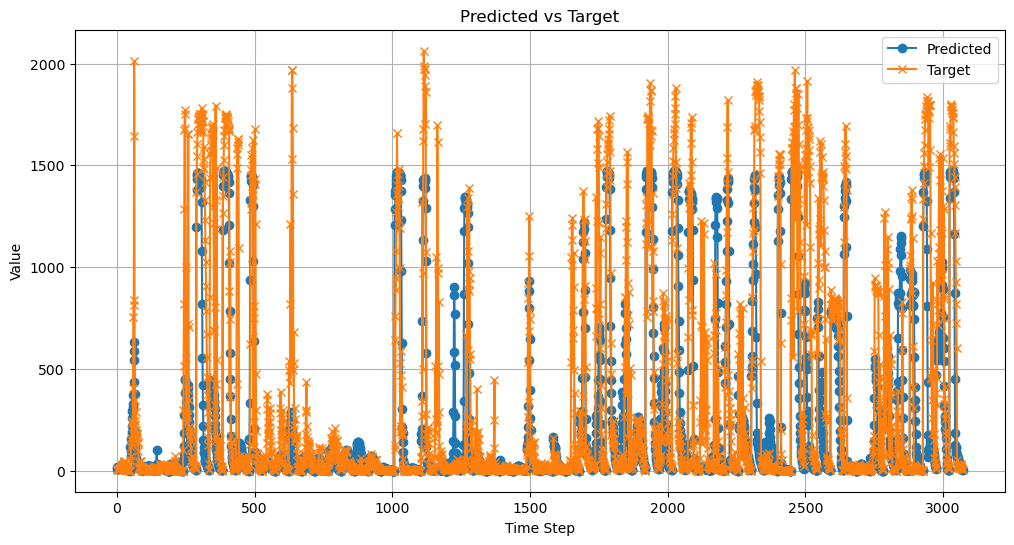

In [24]:
datas, support_datas, labels = valid_loader[0]

hidden = model.init_hidden(batch)
hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

datas, support_datas, labels = datas.to('cuda', dtype=torch.float32), support_datas.to('cuda', dtype=torch.float32), labels.to('cuda', dtype=torch.float32)

predicted, _ = model(datas, support_datas, hidden)
predicted = predicted.detach().to('cpu').numpy()
target = labels.to('cpu').numpy()


predicted_plot = predicted.reshape(-1)
target_plot = target.reshape(-1)

# 繪製折線圖
plt.figure(figsize=(12, 6))
plt.plot(predicted_plot, label='Predicted', marker='o')
plt.plot(target_plot, label='Target', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predicted vs Target')
plt.legend()
plt.grid()
plt.show()


In [25]:
#取得上傳用資料
upload, upload_target_list = get_upload_target_list()
upload_data_batch, upload_support_data_batch = get_upload_data_list(target_df, upload_target_list)
upload_loader = list(zip(upload_data_batch, upload_support_data_batch))

In [26]:
min_num, max_num = 1e9, 0

for data in upload_data_batch:
    min_num = min(len(data), min_num)
    max_num = max(len(data), max_num)
print(min_num, max_num)

125 241


In [27]:


model.eval()
ans = []
with torch.no_grad():
    for datas, support_datas in upload_loader:
        # 將輸入和標籤移到 GPU
        datas, support_datas = datas.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float)
        datas = datas.view(1, -1, datas.shape[1])
        support_datas = support_datas.view(1, -1, support_datas.shape[1])
        # 初始化隱藏狀態
        hidden = model.init_hidden(batch_size=datas.size(0))
        hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

        # 前向傳播
        outputs, _ = model(datas, support_datas, hidden)

        outputs = outputs.to('cpu', dtype=torch.float32)
        ans.extend(outputs.view(-1).tolist())



        

In [28]:
upload['答案'] = np.array(ans)
upload.to_csv('try.csv', index=False)